In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import torchvision
import torchvision.transforms as transforms

# for reproducibility
np.random.seed(12)
torch.manual_seed(12)

In [2]:
BATCH_SIZE = 64
# set to true to see progress on test set
EVAL = False
fashion_classes = ['T-shirt/top',
                   'Trouser',
                   'Pullover', 
                   'Dress', 
                   'Coat',
                   'Sandal', 
                   'Shirt', 
                   'Sneaker', 
                   'Bag', 
                   'Ankle boot']

In [3]:
# set normalize to precalculated dataset mean
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize((0.1307,), (0.3081,))])

trainset = torchvision.datasets.FashionMNIST(root='data/fashion/',
                                             train=True,
                                             download=True,
                                             transform=transform)

testset = torchvision.datasets.FashionMNIST(root='data/fashion/',
                                            train=False,
                                            download=True,
                                            transform=transform)

In [4]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f'Training on {format(device)}')

Training on cuda:0


In [5]:
trainloader = torch.utils.data.DataLoader(trainset,
                                          batch_size=BATCH_SIZE,
                                          shuffle=True,
                                          num_workers=2)
testloader = torch.utils.data.DataLoader(testset,
                                         batch_size=BATCH_SIZE,
                                         shuffle=False,
                                         num_workers=2)

Labels:  tensor(9)
Batch shape:  torch.Size([64, 1, 28, 28])


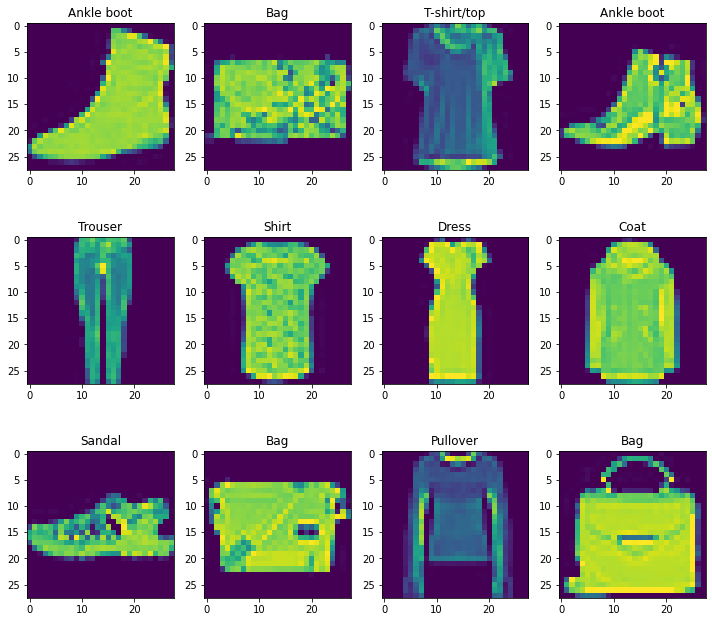

In [6]:
def show_batch(images, labels):
    fig, axes = plt.subplots(3, 4,figsize=(10,10))
    counter = 0
    for row in axes:
        for axe in row:
            index = counter
            counter = counter + 1
            img = images[index]
            obj = labels[index]
            axe.imshow(np.transpose(img.numpy(), (1, 2, 0)))
            axe.set_title(fashion_classes[obj])
            plt.tight_layout()

# choose random batch to display
dataiter = iter(trainloader)

images, labels = dataiter.next()

print('Labels: ', labels[0])
print('Batch shape: ', images.size())
show_batch(images, labels)

In [7]:
# total number of weights in the model
def total_number_of_weights(model):
    return sum([val.numel() for key, val in model.state_dict().items()])

In [8]:
# train and count accuracy
def train_and_evaluate_model(model,
                             criterion,
                             optimizer,
                             num_epochs=10,
                             save_every_nth_batch_loss=50):
    """Train and evaluate the classification model."""
    run_hist = {key: [] for key in ['epoch_loss_train',
                                    'epoch_acc_train',
                                    'epoch_loss_test',
                                    'epoch_acc_test',
                                    'batch_loss_train']}
    max_train_acc = 0.0
    try:
        for epoch in range(num_epochs):
            print('Epoch {}/{}'.format(epoch+1, num_epochs))
            print('-' * 10)

            # training phase
            model.train()

            running_loss_train = 0.0
            running_corrects_train = 0

            i = 0
            for inputs, labels in trainloader:
                inputs = inputs.to(device)
                labels = labels.to(device)

                outputs = model(inputs)
                loss = criterion(outputs, labels)

                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

                _, preds = torch.max(outputs, 1)
                running_loss_train += loss.detach() * inputs.size(0)
                running_corrects_train += torch.sum(preds == labels.data)

                if i % save_every_nth_batch_loss == 0:
                    run_hist['batch_loss_train'].append(loss.item())
                i += 1

            epoch_loss_train = running_loss_train / len(trainset)
            epoch_acc_train = running_corrects_train.float() / len(trainset)

            print('train loss: {:.4f}, train acc: {:.4f}'.\
            format(epoch_loss_train.item(),
                   epoch_acc_train.item()))

            run_hist['epoch_loss_train'].append(epoch_loss_train.item())
            run_hist['epoch_acc_train'].append(epoch_acc_train.item())

            if epoch_acc_train > max_train_acc:
                max_train_acc = epoch_acc_train
                torch.save(model.state_dict(), 'model.pt')

            # evaluating phase, disabled by default
            if EVAL:
                model.eval()
    
                running_loss_test = 0.0
                running_corrects_test = 0
    
                for inputs, labels in testloader:
                    inputs = inputs.to(device)
                    labels = labels.to(device)
    
                    outputs = model(inputs)
                    loss = criterion(outputs, labels)
    
                    _, preds = torch.max(outputs, 1)
                    running_loss_test += loss.detach() * inputs.size(0)
                    running_corrects_test += torch.sum(preds == labels.data)
    
                epoch_loss_test = running_loss_test / len(testset)
                epoch_acc_test = running_corrects_test.float() / len(testset)
    
                print('test loss: {:.4f}, test acc: {:.4f}\n'.\
                format(epoch_loss_test.item(),
                       epoch_acc_test.item()))
    
                run_hist['epoch_loss_test'].append(epoch_loss_test.item())
                run_hist['epoch_acc_test'].append(epoch_acc_test.item())
    except KeyboardInterrupt:
        pass
    return model, run_hist

In [9]:
# Lets' plot the progress of the training
def plot_training(run_hist):
    """Plot the training history of the classification model."""
    fig, ax = plt.subplots(1,2, figsize=(20,6), sharex=True)
    x = np.arange(len(run_hist["epoch_loss_train"])) + 1
    ax[0].plot(x, run_hist["epoch_loss_train"],'b', marker='.', label="epoch train loss")
    if EVAL:
        ax[0].plot(x, run_hist["epoch_loss_test"],'r', marker='.', label="epoch test loss")
    ax[0].legend()
    ax[1].plot(x, run_hist["epoch_acc_train"],'b', marker='.', label="epoch train accuracy")
    if EVAL:
        ax[1].plot(x, run_hist["epoch_acc_test"],'r', marker='.', label="epoch test accuracy")
    ax[1].legend()
    
    fig, ax = plt.subplots(1,1, figsize=(20,6), sharex=True)
    x = np.arange(len(run_hist["batch_loss_train"])) + 1
    ax.plot(x, run_hist["batch_loss_train"], 'b',  marker='.', label="batch train loss")
    ax.legend()


# Lets' plot some predictions!
def plot_predictions(model, number_of_images=10):
    """Plot predictions for some randomly chosen images."""
    inputs, labels = next(iter(testloader))
    inputs = inputs.to(device)
    labels = labels.to(device)
    model.eval()
    with torch.no_grad():
        preds = F.softmax(model(inputs), dim=1)

    nr_final = min(preds.shape[0], number_of_images)
    fig, axs = plt.subplots(nr_final, 2, figsize=(8, 2.5 * nr_final))
    plt.subplots_adjust(hspace=0.5)

    idxs = np.random.choice(preds.shape[0], nr_final, replace=False)

    for i,idx in enumerate(idxs):
        ax = axs[i,0]
        img = np.asarray(transforms.ToPILImage()(inputs[idx].cpu() / 2 + 0.5))
        ax.imshow(img, interpolation='none')
        ax.set_title(fashion_classes[labels[idx]])
        ax.axis('off')
        pd.Series(preds[idx].detach().cpu().numpy(), index=fashion_classes)\
        .plot(kind='bar', ax=axs[i,1], ylim=[0,1])


In [10]:
# prepare csv with classifications for test dataset
def prepare_csv():
    model_conv.load_state_dict(torch.load('model.pt'))
    model_conv.eval()
    predictions = []

    with torch.no_grad():
        for batch_idx, (data, targets) in enumerate(testloader):
        
            data = data.to(device)
            out = model_conv(data)
            indexes = torch.arange(len(out)) + batch_idx*BATCH_SIZE
            for index, pred in zip(indexes, torch.argmax(out, dim=1)):
                predictions.append([index.item(), pred.item()])

    csv = pd.DataFrame(predictions, columns=['Id', 'Class'])
    csv.to_csv('kaggle.csv', index=False)

    print(csv.head())

In [11]:
class ConvNet(nn.Module):
  def __init__(self):
    super().__init__()
    self.conv1 = nn.Conv2d(1,32, kernel_size=3, padding=1)
    self.relu = nn.ReLU(inplace=True)
    self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

    self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
    self.drop = nn.Dropout()
    self.fc1 = nn.Linear(64 * 7 * 7, 128)
    self.fc2 = nn.Linear(128, 10)

  def forward(self, x):
    x = self.conv1(x)
    x = self.relu(x)
    x = self.pool(x)
    x = self.conv2(x)
    x = self.relu(x)
    x = self.pool(x)

    x = x.view(x.size(0), 64 * 7 * 7)
    x = self.drop(x)
    x = self.fc1(x)
    x = self.relu(x)
    x = self.fc2(x)
    return x

In [12]:
model_conv = ConvNet().to(device)

In [13]:
total_number_of_weights(model_conv)

421642

In [14]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_conv.parameters())

In [15]:
model_conv, run_hist_conv = train_and_evaluate_model(model_conv, criterion, optimizer, num_epochs=50)

Epoch 1/50
----------
train loss: 0.4514, train acc: 0.8364
Epoch 2/50
----------
train loss: 0.3088, train acc: 0.8866
Epoch 3/50
----------
train loss: 0.2647, train acc: 0.9031
Epoch 4/50
----------
train loss: 0.2392, train acc: 0.9115
Epoch 5/50
----------
train loss: 0.2201, train acc: 0.9184
Epoch 6/50
----------
train loss: 0.2042, train acc: 0.9241
Epoch 7/50
----------
train loss: 0.1899, train acc: 0.9280
Epoch 8/50
----------
train loss: 0.1827, train acc: 0.9319
Epoch 9/50
----------
train loss: 0.1694, train acc: 0.9365
Epoch 10/50
----------
train loss: 0.1595, train acc: 0.9404
Epoch 11/50
----------
train loss: 0.1533, train acc: 0.9417
Epoch 12/50
----------
train loss: 0.1458, train acc: 0.9446
Epoch 13/50
----------
train loss: 0.1394, train acc: 0.9473
Epoch 14/50
----------
train loss: 0.1334, train acc: 0.9497
Epoch 15/50
----------
train loss: 0.1277, train acc: 0.9508
Epoch 16/50
----------
train loss: 0.1214, train acc: 0.9542
Epoch 17/50
----------
train loss

In [16]:
prepare_csv()

   Id  Class
0   0      9
1   1      2
2   2      1
3   3      1
4   4      6


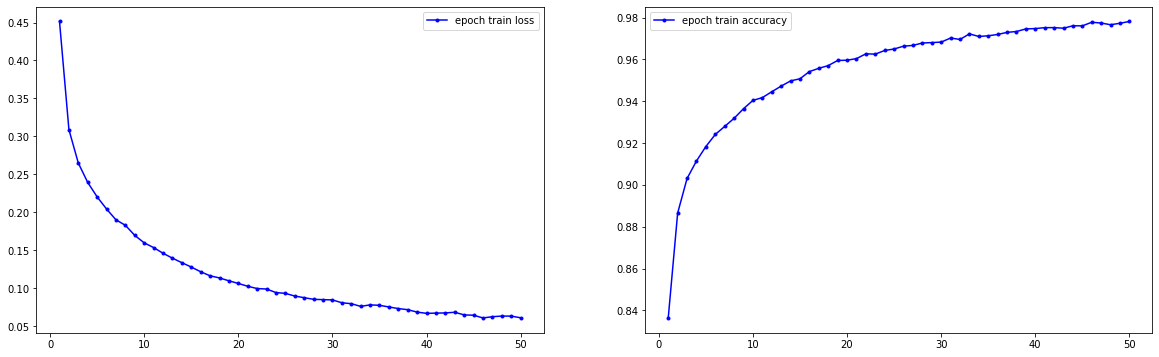

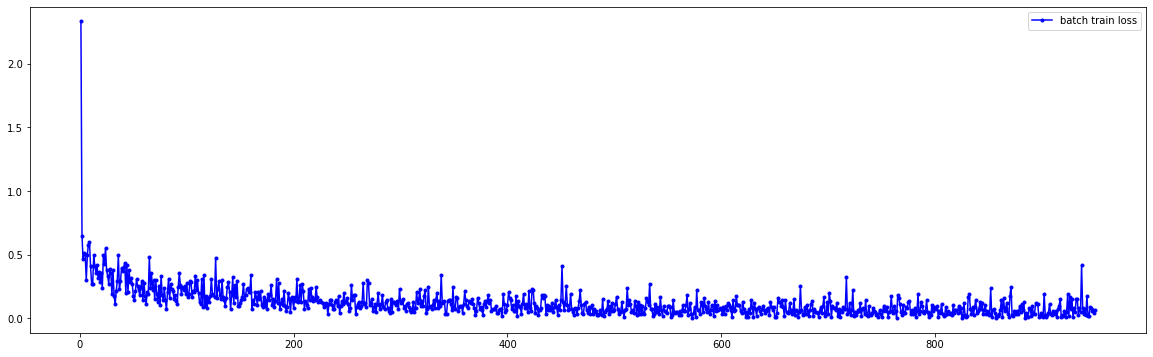

In [17]:
plot_training(run_hist_conv)

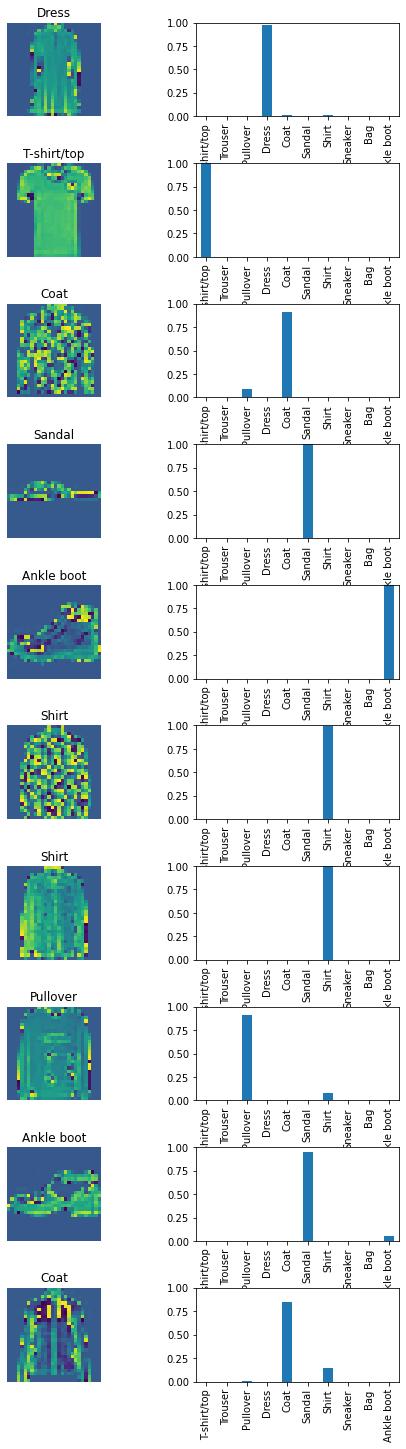

In [18]:
plot_predictions(model_conv)